In [27]:
# Helper packages
import numpy as np
import pandas as pd
from plotnine import *
from scipy.stats import uniform, randint
import seaborn as sns

# Modeling packages
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

### Read the data

<AxesSubplot:>

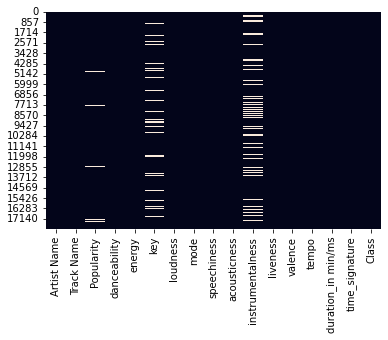

In [28]:
# read the raw data
music_df = pd.read_csv('../data/5254074447627840549music.csv')

# Visulaize the missing data
sns.heatmap(music_df.isnull(), cbar=False)

In [29]:
# read the cleaned data after filling the missing 
music_df = pd.read_csv('../data/music_dataset_cleaned.csv')

# transfer the Class colum to object
music_df.Class = music_df.Class.astype(str)
 
# Delete tge track Name as we dont need it
del music_df['Track Name']

# Save the the columns name in col_list variable 
col_list = list(music_df.columns) 

### Encode the Artist Name
We need to encode the artist column as it is a string. We will work on temp dataframe then we will copy the column in our dataframe

In [30]:
music_df['Artist Name'].value_counts()

Backstreet Boys    69
Westlife           60
Britney Spears     54
Omer Adam          48
Eyal Golan         48
                   ..
Rocky Trail         1
Smerz               1
lavender            1
Fear Culture        1
Beherit             1
Name: Artist Name, Length: 9149, dtype: int64

In [31]:
temp_df = music_df.iloc[:,:].values
Artist = LabelEncoder()
temp_df[:,1]=Artist.fit_transform(temp_df[:,1])
ct = ColumnTransformer(transformers=[('Artistencode'),OneHotEncoder,[1]], remainder='passthrough')
temp_df = pd.DataFrame(temp_df, columns=col_list)
music_df['Artist Name'] = temp_df['Artist Name']
music_df['Artist Name'] = music_df['Artist Name'].astype(int)


In [32]:
music_df['Artist Name'].value_counts()

699     69
8604    60
1156    54
5722    48
2515    48
        ..
6445     1
7035     1
9013     1
2597     1
797      1
Name: Artist Name, Length: 9149, dtype: int64

## Split the Data

In [33]:
# create train/test split
class_col = music_df.Class
music_train, music_test = train_test_split(music_df, train_size=0.7, random_state=123, stratify=class_col)

In [34]:
# separate features from labels and only use numeric features
x_train = music_train.drop("Class", axis=1)
y_train = music_train[["Class"]]    

# separate features from labels and only use numeric features
x_test = music_test.drop("Class", axis=1)
y_test = music_test[["Class"]]    

## Select Features
We will find which features have the most dependency on the target  

In [35]:
from sklearn.feature_selection import mutual_info_classif
#determine the mutual information
mutual_info = mutual_info_classif(x_train, y_train)
mutual_info

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


array([0.        , 0.54006917, 0.10125407, 0.16993873, 0.21347325,
       0.02547372, 0.1236263 , 0.0136935 , 0.15185389, 0.27714245,
       0.17397138, 0.02761965, 0.09507628, 0.06893274, 0.36182362,
       0.02008824])

<AxesSubplot:>

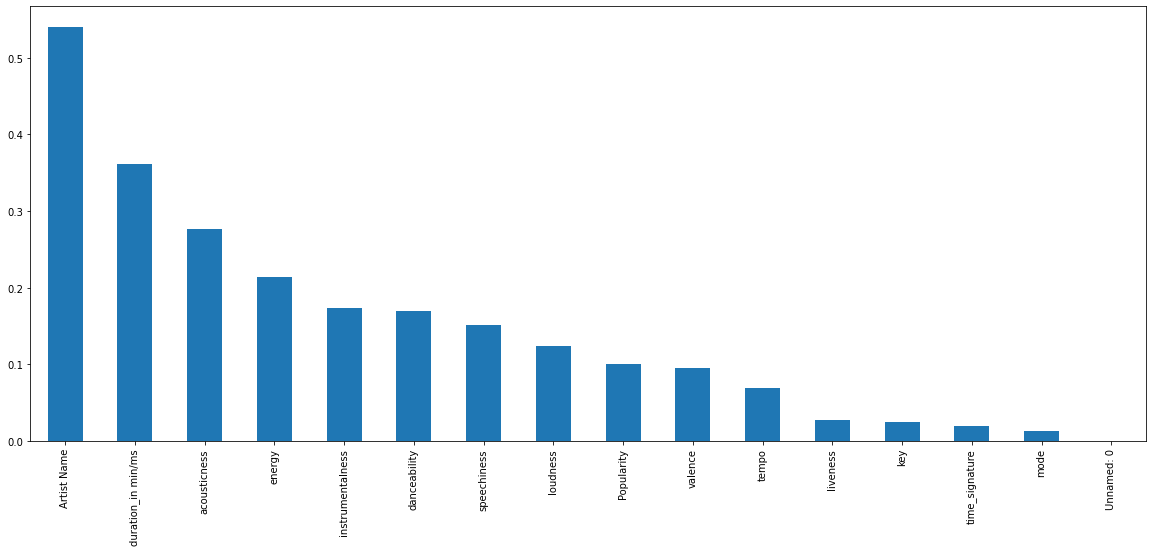

In [36]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train.columns
mutual_info.sort_values(ascending=False)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,8))

In [37]:
from sklearn.feature_selection import SelectKBest
# select the most 4 independed colume
sel_five_cols = SelectKBest(mutual_info_classif, k=4)
sel_five_cols.fit(x_train,y_train.values.ravel())
selected_features = x_train.columns[sel_five_cols.get_support()]
selected_features = selected_features.tolist()

In [38]:
selected_features

['Artist Name', 'energy', 'acousticness', 'duration_in min/ms']

## Feature Scaling
Scale the data

In [39]:
stander = StandardScaler()
x_train = pd.DataFrame(stander.fit_transform(x_train), columns=col_list[0:16])
x_test = pd.DataFrame(stander.fit_transform(x_test), columns=col_list[0:16])

## Cross Validation & HyperParameter Tunning

In [40]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,50,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,return_train_score=False)
CV_rfc.fit(x_train, y_train.values.ravel())

KeyboardInterrupt: 

In [ ]:
CV_rfc.best_params_

## Test the model

Accuracy for Random Forest on CV data:  0.5084274865715873


Text(69.0, 0.5, 'Truth')

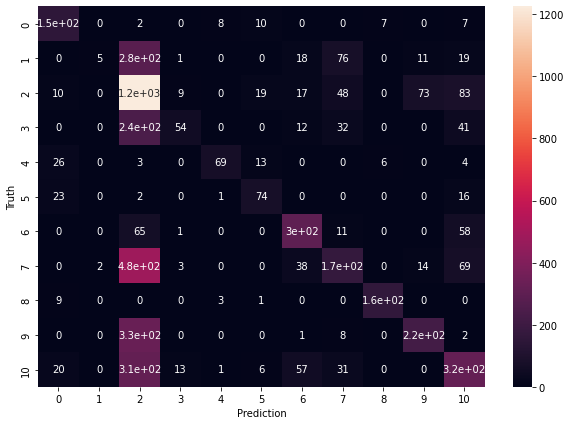

In [41]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score

rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 100, max_depth=8, criterion='entropy')
rfc1.fit(x_train, y_train.values.ravel())
y_pred = rfc1.predict(x_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)
import matplotlib.pyplot as plt
import seaborn as sn 
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Truth')

